In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
from matplotlib import pyplot as plt

from mtt.visualize import plot_mtt

rng = np.random.default_rng()

In [34]:
from mtt.simulator import Simulator
from mtt.data import OnlineDataset

def init_simulator():
    return Simulator()

online_dataset = OnlineDataset(n_steps=100, sigma_position=10, length=20, img_size=128, init_simulator=init_simulator)
dataset = list(online_dataset)

In [35]:
positions = [info[-1]["target_positions"] for *_, info in dataset]
n_targets = np.zeros(len(positions))
for i, pos in enumerate(positions):
    n_targets[i] = (np.abs(pos) < 500).all(axis=1).sum(axis=0)
print(f"# of targets: mean = {np.mean(n_targets):0.2f}, std = {np.std(n_targets):0.2f}")
print(f"position std: {np.std(np.concatenate(positions), axis=0)}")

# of targets: mean = 11.91, std = 1.94
position std: [1063.11121061  994.33951442]


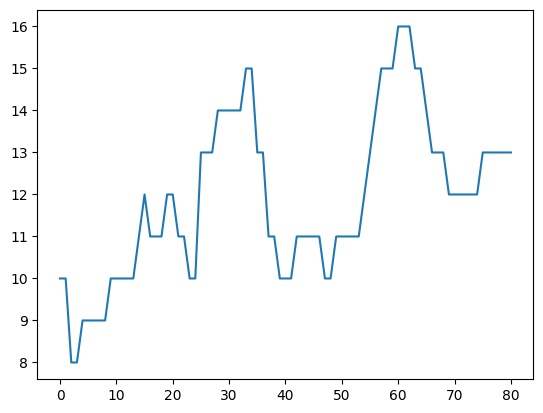

In [36]:
plt.plot(n_targets)

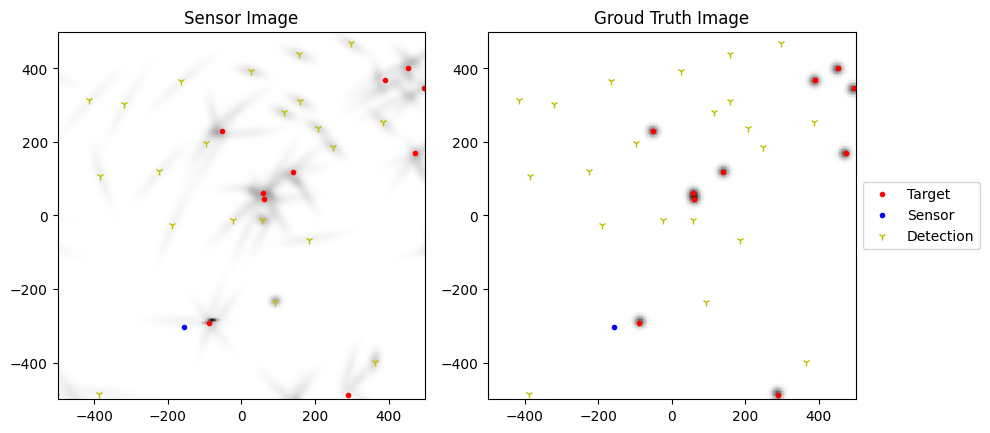

In [37]:
plot_mtt(*dataset[0])
plt.show()

In [11]:
import pickle as pkl

data_binary = pkl.dumps(dataset)
len(data_binary) / 1024**2

204.2032585144043